In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
import optuna
import warnings
warnings.filterwarnings('ignore')

In [88]:
train=pd.read_csv('../Data/train_MpHjUjU.csv',parse_dates=['MMM-YY','Dateofjoining','LastWorkingDate'])
test=pd.read_csv('../Data/test_hXY9mYw.csv')
train.shape, test.shape

((19104, 13), (741, 1))

Text(0.5, 1.0, 'HIstogram of No. of months worked before leaving')

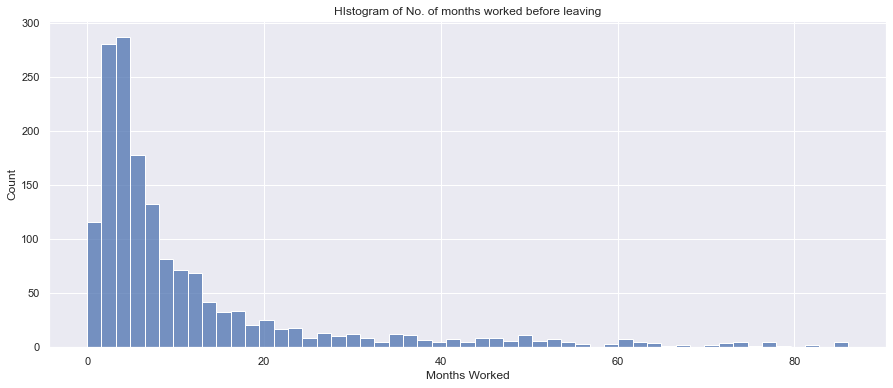

In [12]:
def func(sub):
    return pd.Series([(sub['LastWorkingDate'].iloc[-1]-sub['Dateofjoining'].iloc[-1]).days/30,(sub['MMM-YY'].iloc[-1]-sub['Dateofjoining'].iloc[-1]).days/30])
df=train.groupby(['Emp_ID']).apply(func).reset_index()
df.columns=['EMp_ID','Months Worked','Months Since Joined']
sns.set(rc={'figure.figsize':(15,6)})
sns.histplot(data=df.dropna(),x='Months Worked').set_title('Histogram of No. of months worked before leaving')

* Employees usually leave the organization within the first year

Text(0.5, 1.0, 'Average Tenure by City and Education Level')

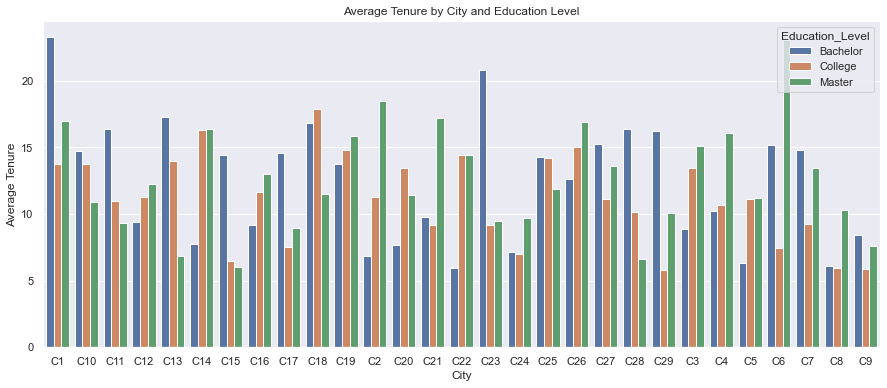

In [13]:
df=train.groupby(['Education_Level','City']).apply(lambda x:np.nanmean((x['LastWorkingDate']-x['Dateofjoining']).dt.days)/30).reset_index()
df.columns=[*df.columns[:-1]]+['Average Tenure']
sns.barplot(data=df,x='City',y='Average Tenure',hue='Education_Level').set_title('Average Tenure by City and Education Level')

In [ ]:
* In cities C1,C11,C13,C23,C27,C28 and C29, employees with Bachelor education level on an average stay longest with a miniumum tenure of 15 months
* In cities C19,C2,C21,C26,C3,C4 and C6, employees with Master education level on an average stay longest with a miniumum tenure of 15 months

In [89]:
df=train.groupby(['Education_Level','Gender','City']).apply(lambda x:np.nanmean((x['LastWorkingDate']-x['Dateofjoining']).dt.days)/30).reset_index()
df.columns=[*df.columns[:-1]]+['avgEduGenCityTenure']
train=pd.merge(train,df)

df=train.groupby(['Education_Level','Gender','City']).apply(lambda x:x['Salary'].mean()).reset_index()
df.columns=[*df.columns[:-1]]+['avgEduGenCitySalary']
train=pd.merge(train,df)
train['avgSalDiff']=train['Salary']-train['avgEduGenCitySalary']

df=train.groupby(['Education_Level','Gender','City']).apply(lambda x:x['Age'].mean()).reset_index()
df.columns=[*df.columns[:-1]]+['avgEduGenCityAge']
train=pd.merge(train,df)
train['avgAgeDiff']=train['Salary']-train['avgEduGenCityAge']

df=train.groupby(['Education_Level','City']).apply(lambda x:sum(x['Gender']=='Female')/len(x)).reset_index()
df.columns=[*df.columns[:-1]]+['femaleRatio']
train=pd.merge(train,df)

df=train.groupby(['Education_Level','City']).apply(lambda x:np.mean(x['Age'][x['Gender']=='Female'])).reset_index()
df.columns=[*df.columns[:-1]]+['avgFemaleAge']
train=pd.merge(train,df)

df=train.groupby(['Education_Level','City']).apply(lambda x:np.mean(x['Age'][x['Gender']=='Male'])).reset_index()
df.columns=[*df.columns[:-1]]+['avgMaleAge']
train=pd.merge(train,df)

In [90]:
def preprocess(sub):
    sub['LastWorkingDate']=sub['LastWorkingDate'].iloc[-1]
    sub['monthsSinceJoined']=((sub['MMM-YY']-sub['Dateofjoining']).dt.days)/30
    sub['changeInSal']=(sub['Salary']-sub['Salary'].iloc[0])/sub['Salary'].iloc[0]
    sub['changeInDesig']=sub['Joining Designation']-sub['Joining Designation'].shift(1)
    sub['changeInDesigFromInitial']=sub['Designation']-sub['Joining Designation']
    sub['monthlyNet']=(sub['Total Business Value']-sub['Salary'])/sub['Salary']
    sub['prevQuatRate']=sub['Quarterly Rating'].shift(1)
    sub['quatRateDiff']=sub['Quarterly Rating']-sub['prevQuatRate']
    sub['cumSalary']=sub['Salary'].cumsum()
    sub['cumTotBusValue']=sub['Total Business Value'].cumsum()
    sub['meanQuatRate']=sub['Quarterly Rating'].expanding().mean()
    sub['cumNet']=(sub['cumTotBusValue']-sub['cumSalary'])/sub['cumSalary']
    sub['meanCumNet']=sub['cumNet'].expanding().mean()
    
    t=np.where(sub['Salary']-sub['Salary'].shift(1)>0)[0]
    if len(t==1):
        sub['timeSinceSalChange']=np.concatenate((np.tile(0,t),np.arange(1,len(sub)-t+1)))
    else:
        sub['timeSinceSalChange']=0
    return sub

train=train.groupby('Emp_ID').apply(preprocess)
train['target']=(((train['LastWorkingDate']-train['MMM-YY']).dt.days)<180)*1
train['target'].fillna(0,inplace=True)

In [81]:
np.sum(train[['Age','Gender','Emp_ID','City','Education_Level','Salary','Dateofjoining','Joining Designation','Designation','Quarterly Rating']].groupby('Emp_ID').nunique().reset_index()!=1)

* Gender, City, Education_Level, Dateofjoining,Joining Designation contain only 1 value per employee as expected

In [91]:
test=train[(train['Emp_ID'].isin(test['Emp_ID'])) & (train['MMM-YY']==pd.to_datetime('2017-12-01',format='%Y-%m-%d'))]
train=train[train['MMM-YY']<pd.to_datetime('2017-08-01',format='%Y-%m-%d')]
print (train.shape,test.shape)

(15041, 35) (741, 35)


In [92]:
drop_cols=['MMM-YY','Emp_ID','Dateofjoining','LastWorkingDate','target']
cat_cols=list(set(train.columns[train.dtypes=='object'])-set(drop_cols))
num_cols=list(set(train.columns)-set(cat_cols+drop_cols))

train_X=train[cat_cols+num_cols]
train_X[cat_cols]=train_X[cat_cols].astype('category')
train_Y=train['target']

test_X=test[cat_cols+num_cols]
test_X[cat_cols]=test_X[cat_cols].astype('category')

params_cb={'learning_rate':0.02,'n_estimators':1000,'random_state':123,'cat_features':cat_cols}
fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=12345)
cb_scores,pred_cb,feat_scores=[],[],[]
for idxT, idxV in fold.split(train_X, train_Y):
    df_trainX,df_trainY=train_X.iloc[idxT],train_Y.iloc[idxT]
    df_evalX,df_evalY=train_X.iloc[idxV],train_Y.iloc[idxV]
    
    cb=CatBoostClassifier(**params_cb,early_stopping_rounds=50,eval_metric='F1')
    cb.fit(df_trainX,df_trainY,eval_set=(df_evalX,df_evalY),plot=False, verbose=0)
    cb_scores.append(cb.get_best_score().get('validation').get('F1'))
    pred_cb.append(cb.predict_proba(test_X)[:,1])
    feat_scores.append(cb.get_feature_importance())
    print ('{} at {}'.format(cb.get_best_score().get('validation').get('F1'),cb.get_best_iteration()))
    
weights=cb_scores/sum(np.array(cb_scores))
print ('The local CV is {}'.format(np.sum(weights*cb_scores)))

0.8153065208902773 at 991
0.8022151898734178 at 993
0.7215815485996704 at 2
0.8081761006289309 at 986
0.8025579536370903 at 791
The local CV is 0.7914760774920917


In [93]:
test['Target']=np.sum(weights*np.transpose(pred_cb),1)
test['Target']=(test['Target']>0.5)*1
test[['Emp_ID','Target']].to_csv('../Submissions/submit6.csv',index=False)
print (test['Target'].sum())

302


In [94]:
featureImp=pd.DataFrame({'feature':train_X.columns,'importance':np.mean(np.array(feat_scores),0)})
featureImp=featureImp.sort_values('importance',ascending=False)
featureImp['importance']=featureImp['importance']*100/featureImp['importance'].sum()
featureImp.reset_index(drop=True)

feature  importance
0           Quarterly Rating   15.476540
1          monthsSinceJoined    9.843914
2        avgEduGenCityTenure    8.205228
3                        Age    5.445189
4                  cumSalary    5.159794
5           avgEduGenCityAge    4.871505
6               meanQuatRate    4.844291
7                 avgSalDiff    4.656939
8   changeInDesigFromInitial    3.870681
9                Designation    3.730144
10                    Salary    3.345427
11                avgAgeDiff    3.247165
12                      City    3.213869
13                avgMaleAge    2.892603
14                    cumNet    2.803070
15              avgFemaleAge    2.657876
16       avgEduGenCitySalary    2.611193
17                meanCumNet    2.499995
18               femaleRatio    1.955076
19            cumTotBusValue    1.899064
20           Education_Level    1.550762
21       Joining Designation    1.192330
22              prevQuatRate    1.182641
23      Total Business Value    1.038936
24                monthlyNet    0.684917
25              quatRateDiff    0.491150
26                    Gender    0.388283
27             changeInDesig    0.237739
28               changeInSal    0.002756
29        timeSinceSalChange    0.000924